In [ ]:
from typing import Optional, Literal
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import time
import os


#models 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

#Gridsearch, CV and optimisation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectPercentile


#Scalers
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Explainability
import shap


**Helper functions**

In [2]:
# Let write a few useful function we can then call when needed 

def tryThisModel(Model : Literal['Lasso', 'Ridge', 'Random Forest','SVR','Gradient Boosting', 'XGBoost'],
                X,
                y,
                param_grid : Optional[dict] = None,
                best_parameters : Optional[dict] = None,
                shap_explain : Optional[bool] = True):
    """
    Please make sure the param_grid you pass works for the model, if you're not sure just don't input one the function will use one by default
    ------------------------------------------------
    """
    start_time = time.time()
    # Perform one-hot encoding on categorical columns
    categorical_cols = X.select_dtypes(include='object').columns
    if not categorical_cols.empty:
        X_encoded = pd.get_dummies(X)
    else:
        X_encoded = X
    
    # Split the encoded data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=1)
    
    
    # Check for constant columns in the encoded dataset
    constant_cols_train = X_train.columns[X_train.nunique() == 1]
    constant_cols_test = X_test.columns[X_test.nunique() == 1]
    # Get the union of constant columns in both datasets
    constant_cols_all = set(constant_cols_train) | set(constant_cols_test)

    # Remove constant columns from both X_train and X_test
    if len(constant_cols_all) !=0:
        X_train = X_train.drop(columns=constant_cols_all)
        X_test = X_test.drop(columns=constant_cols_all)

    
    # Perform min-max scaling on numerical columns except uint8 dtype
    numerical_cols = X_train.select_dtypes(include=np.number).columns
    uint8_cols = X_train.select_dtypes(include='uint8').columns
    numerical_cols = numerical_cols.difference(uint8_cols)
    scaler = StandardScaler()
    X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test[numerical_cols] = scaler.fit_transform(X_test[numerical_cols])
    
    
    # Initialize the model
    if Model == 'Gradient Boosting':
        model = GradientBoostingRegressor()
        selector = SelectPercentile(score_func=f_regression)
        pipeline = Pipeline(steps=[('s', selector), ('m', model)])
        
        if param_grid is None:
            param_grid = {'s__percentile': [10, 25, 50, 70, 90, 100],  # Percentage of features to select
                          'm__n_estimators': [100, 200, 300,500],
                          'm__learning_rate': [0.1, 0.05, 0.01]}
            
    elif Model == 'Lasso':
        model = Lasso()
        selector = SelectPercentile(score_func=f_regression)
        pipeline = Pipeline(steps=[('s', selector), ('m', model)])

        if param_grid is None:
            param_grid = {'s__percentile': [10, 25, 50, 70, 90, 100],  # Percentage of features to select
                          'm__alpha': [0.1, 1.0, 10.0]}
            
    elif Model == 'Ridge':
        model = Ridge()
        selector = SelectPercentile(score_func=f_regression)
        pipeline = Pipeline(steps=[('s', selector), ('m', model)])

        if param_grid is None:
            param_grid = {'s__percentile': [10, 25, 50, 70, 90, 100],  # Percentage of features to select
                          'm__alpha': [0.1, 1.0, 10.0]}         

    elif Model == 'Random Forest':
        model = RandomForestRegressor()
        selector = SelectPercentile(score_func=f_regression)
        pipeline = Pipeline(steps=[('s', selector), ('m', model)])

        if param_grid is None:
            param_grid = {'s__percentile': [10, 25, 50, 70, 90, 100],  # Percentage of features to select
                          'm__n_estimators': [100, 200, 300],
                          'm__max_depth': [None, 5, 10]}
            
    elif Model == 'SVR':
        model = SVR()
        selector = SelectPercentile(score_func=f_regression)
        pipeline = Pipeline(steps=[('s', selector), ('m', model)])

        if param_grid is None:
            param_grid = {'s__percentile': [10, 25, 50, 70, 90, 100],  # Percentage of features to select
                          'm__kernel': ['linear', 'rbf']}
            
    elif Model == 'XGBoost':
        model = XGBRegressor()
        selector = SelectPercentile(score_func=f_regression)
        pipeline = Pipeline(steps=[('s', selector), ('m', model)])

        if param_grid is None:
            param_grid = {'s__percentile': [10, 25, 50, 70, 90, 100],  # Percentage of features to select
                          'm__n_estimators': [100, 200, 300, 500],
                          'm__learning_rate': [0.1, 0.05, 0.01]}

    if best_parameters is None :  
        # Perform grid search using cross-validation
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, error_score='raise')
        grid_search.fit(X_train, y_train)

        # Get the best parameters and best score
        best_params = grid_search.best_params_
        best_score = grid_search.best_score_
    else:
        best_params = best_parameters
        
    # Initialize the model with the best parameters
    best_model = pipeline.set_params(**best_params)

    # Fit the best model on the entire dataset
    best_model.fit(X_train, y_train)

    # Make predictions on the test set using the best model
    y_pred = best_model.predict(X_test)

    # Calculate evaluation metrics using the best model
    r2 = r2_score(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)

    # Print the best parameters, best score, and evaluation metrics
    print("Best Parameters:", best_params)
    if best_parameters is None:
        print("Best Score:", best_score)
    print("R2 Score:", r2)
    print("RMSE:", rmse)
    print("MAE:", mae)
    end_time = time.time()
    elapsed_time = end_time - start_time

    if best_parameters is None: saveResults(Model,X,y,best_params,best_score,r2,rmse,mae,elapsed_time)
    if shap_explain: shap_values_explanations(best_model,X_train)
    return  


def saveResults(model,X, y, best_param,best_score,R2score,RMSE,MAE,time):
    """
    Save all the parameters and results of a model to keep track of which one is performing the best through all the iterations
    """
    new_row = {
        'model': model,
        'X' : get_variable_name(X),
        'y' : get_variable_name(y),
        'best_param': str(best_param),
        'best_score': best_score,
        'R2score': R2score,
        'RMSE': RMSE,
        'MAE': MAE,
        'time' : time
    }
    new_row = pd.DataFrame([new_row])
    file_path = 'U://DATA/OpenClassrooms/Data science/P4/result_df.csv'

    if os.path.isfile(file_path):
        # Load the existing file and append the new row
        existing_df = pd.read_csv(file_path)

        # Check if the new row is a duplicate
        checkfordupes = pd.concat([existing_df, new_row], ignore_index=True)
        duplicate_row = checkfordupes.duplicated(subset=['model', 'X', 'y', 'best_param']).any()

        if not duplicate_row:
            # Append the new row
            result_df = pd.concat([existing_df, new_row], ignore_index=True)
            # Save the updated DataFrame to the file
            result_df.to_csv(file_path, index=False)
        else: print("This model was already tried before")

    else:
        # Save the DataFrame as a new file
        columns = ['model', 'X', 'y', 'best_param', 'best_score', 'R2score', 'RMSE', 'MAE','time']
        result_df = pd.DataFrame(columns=columns)
        result_df = pd.concat([result_df, new_row], ignore_index=True)
        result_df.to_csv(file_path, index=False)
    
    return

def get_variable_name(var):
    """
    Retrieve the variable name as a string from a global variable.
    """
    global_vars = globals()
    for name, value in global_vars.items():
        if value is var:
            return name
    return None

def shap_values_explanations(model, X_train):

    explainer = shap.Explainer(model.predict, X_train)
    shap_values = explainer(X_train)    
    shap.plots.bar(shap_values)
    shap.summary_plot(shap_values)
    plt.show()
    return

In [3]:
building_data_clean = pd.read_csv('U://DATA/OpenClassrooms/Data science/P4/building_data_clean.csv', index_col=0)
building_data_energy = pd.read_csv('U://DATA/OpenClassrooms/Data science/P4/building_data_energy.csv', index_col=0)

In [4]:
building_data_energy.describe()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,SiteEnergyUse(kBtu),TotalGHGEmissions,BuildingAge,NaturalGas_Percentage,Electricity_Percentage,SteamUse_Percentage,ParkingGFA_Percentage,Neighborhood_EUI/SF,PrimaryPropertyType_EUI/SF
count,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000,1538.000000
mean,0.701317,1.355289,11.044163,2.235851,10.959620,10.842606,4.812447,1.843296,14.952779,4.029195,61.357607,27.468182,70.039911,2.259383,0.709243,4.314613,4.210146
std,0.238299,0.671280,0.967224,4.327994,0.919439,0.977386,4.940830,3.629293,1.306343,1.444503,32.814073,26.422824,26.318661,9.431839,1.384286,0.198836,0.485527
min,0.000000,0.000000,9.331318,0.000000,8.198914,8.640649,0.000000,0.000000,10.953158,0.336472,8.000000,0.000000,0.000000,0.000000,0.000000,3.905502,2.971743
25%,0.693147,0.693147,10.269042,0.000000,10.235844,10.126881,0.000000,0.000000,14.037535,3.074774,34.250000,0.000000,49.024480,0.000000,0.000000,4.269780,4.061018
50%,0.693147,1.098612,10.779248,0.000000,10.736961,10.644019,0.000000,0.000000,14.817356,3.932119,57.500000,23.303438,70.508285,0.000000,0.000000,4.325498,4.201659
75%,0.693147,1.609438,11.584265,0.000000,11.470576,11.429604,9.526134,0.000000,15.803633,4.999928,93.000000,49.019097,99.999202,0.000000,0.000000,4.493776,4.550527
max,3.332205,4.605170,14.603968,13.147269,14.603968,14.357628,13.369117,13.038436,19.921163,9.733410,123.000000,100.000000,100.000342,76.698738,4.505375,4.921440,5.678260


In [5]:
scaler = MinMaxScaler()
Yenergy = building_data_energy['SiteEnergyUse(kBtu)']
YenergyNorm = scaler.fit_transform(building_data_energy['SiteEnergyUse(kBtu)'].values.reshape(-1, 1))
YenergyNorm = pd.Series(YenergyNorm.flatten())

Yghg = building_data_energy['TotalGHGEmissions']
YghgNorm = scaler.fit_transform(building_data_energy['TotalGHGEmissions'].values.reshape(-1, 1))
YghgNorm = pd.Series(YghgNorm.flatten())



building_data_energy = building_data_energy.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)
building_data_clean = building_data_clean.drop(['SiteEnergyUse(kBtu)', 'TotalGHGEmissions'], axis=1)


**first let's create a baseline for the model using a dummyRegressor**
- We will try to beat that with better and better models

In [7]:
# Split the data into training and testing sets
dummydataset = pd.get_dummies(building_data_energy)
X_train, X_test, y_train, y_test = train_test_split(dummydataset, Yenergy, test_size=0.2, random_state=42)

# Initialize and train the DummyRegressor model
dummy_model = DummyRegressor(strategy='mean')  # You can choose different strategies like 'mean', 'median', 'quantile', or 'constant'
dummy_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_dummy = dummy_model.predict(X_test)

# Calculate evaluation metrics for the dummy model
r2_dummy = r2_score(y_test, y_pred_dummy)
rmse_dummy = mean_squared_error(y_test, y_pred_dummy, squared=False)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

# Print the evaluation metrics for the dummy model
print("Dummy Model - R2 Score:", r2_dummy)
print("Dummy Model - RMSE:", rmse_dummy)
print("Dummy Model - MAE:", mae_dummy)

Dummy Model - R2 Score: -0.0001161549265642492
Dummy Model - RMSE: 1.2942089182501588
Dummy Model - MAE: 1.0148463883292635


--------------------------------
**Time to try different models**

--------------------------------

In [8]:
#different grid for different model 

#GradientBoosting: 
param_gridGB = {'s__percentile': [10, 25, 50, 70, 90, 100],  # Percentage of features to select
                      'm__n_estimators': [100, 200, 300],
                      'm__learning_rate': [0.1, 0.05, 0.01],
                      'm__max_depth': [3, 5, 7],
                      'm__min_samples_split': [2, 4, 6],
                      'm__min_samples_leaf': [1, 2, 3],
                      'm__max_features': ['auto', 'sqrt', 'log2'],
                      'm__subsample': [1.0, 0.8, 0.6]}
            

In [9]:
tryThisModel('XGBoost',building_data_energy,YenergyNorm,shap_explain=False)

Best Parameters: {'m__learning_rate': 0.05, 'm__n_estimators': 200, 's__percentile': 90}
Best Score: 0.7593478005377277
R2 Score: 0.7361286048230858
RMSE: 0.0812336721052737
MAE: 0.06099478562716299
This model was already tried before


------------------------------------------------
Let's look into the best models and results

In [10]:
results = pd.read_csv('U://DATA/OpenClassrooms/Data science/P4/result_df.csv')
print(results.sort_values(by=['best_score'], ascending=False).to_string())

                model                     X             y                                                                best_param  best_score   R2score      RMSE       MAE       time
17            XGBoost                     _     Yghg_star  {'m__learning_rate': 0.05, 'm__n_estimators': 500, 's__percentile': 100}    0.886426  0.858395  0.569509  0.426026  24.303876
18  Gradient Boosting                     _  Yenergy_star   {'m__learning_rate': 0.1, 'm__n_estimators': 500, 's__percentile': 100}    0.885157  0.886678  0.454274  0.345693  20.544304
16            XGBoost                     _            __   {'m__learning_rate': 0.05, 'm__n_estimators': 300, 's__percentile': 70}    0.878491  0.839930  0.539903  0.408379  25.498319
8             XGBoost  building_data_energy      YghgNorm   {'m__learning_rate': 0.05, 'm__n_estimators': 300, 's__percentile': 90}    0.824024  0.815292  0.064901  0.049361  32.415610
7             XGBoost  building_data_energy          Yghg   {'m__learning_r

**Now Lets bring back the EnergyStar data to see if it makes the model better**

In [11]:
building_data = pd.read_csv('U://DATA/OpenClassrooms/Data science/P4/2016_Building_Energy_Benchmarking.csv')

In [12]:
energy_star_data = building_data[['ENERGYSTARScore']].copy()
energy_star_data = energy_star_data.dropna()

In [13]:
#lets merge the two dataframe on the energystar one to only keep the relevent results 
energy_star = pd.merge(energy_star_data, building_data_energy, how='inner', left_index=True, right_index=True)

In [18]:
energy_star_clean = pd.merge(energy_star_data, building_data_clean, how='inner', left_index=True, right_index=True)

In [15]:
#lets change our target to match the energy_star index
Yenergy_star = Yenergy.loc[energy_star.index]
Yghg_star = Yghg.loc[energy_star.index]

In [16]:
param = {'m__learning_rate': 0.05, 'm__n_estimators': 500, 's__percentile': 100}

Best Parameters: {'m__learning_rate': 0.1, 'm__n_estimators': 500, 's__percentile': 90}
Best Score: 0.8767248050129381
R2 Score: 0.8748001549469631
RMSE: 0.5355038817075098
MAE: 0.3862640764749184
This model was already tried before


Permutation explainer: 744it [01:12,  9.18it/s]                         


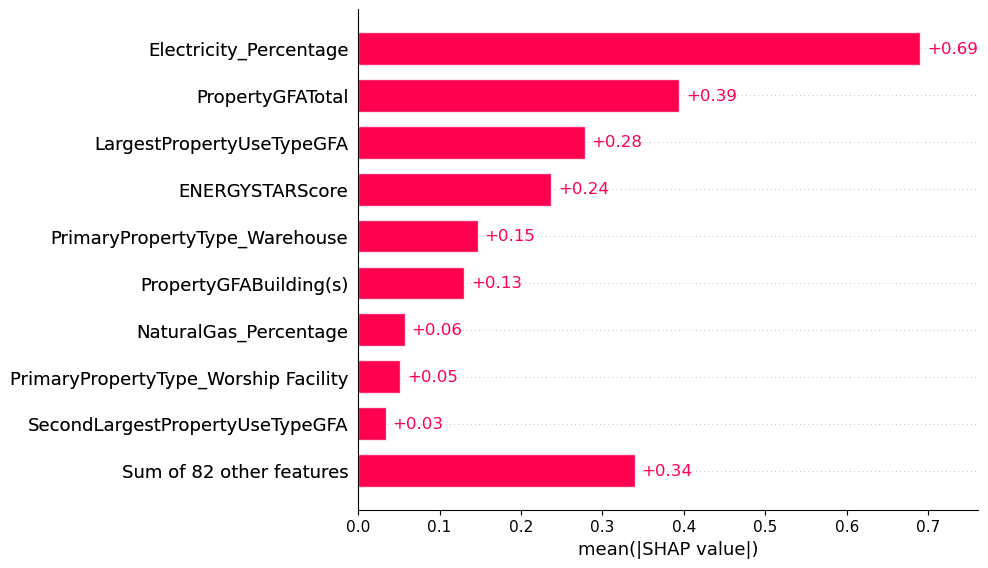

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


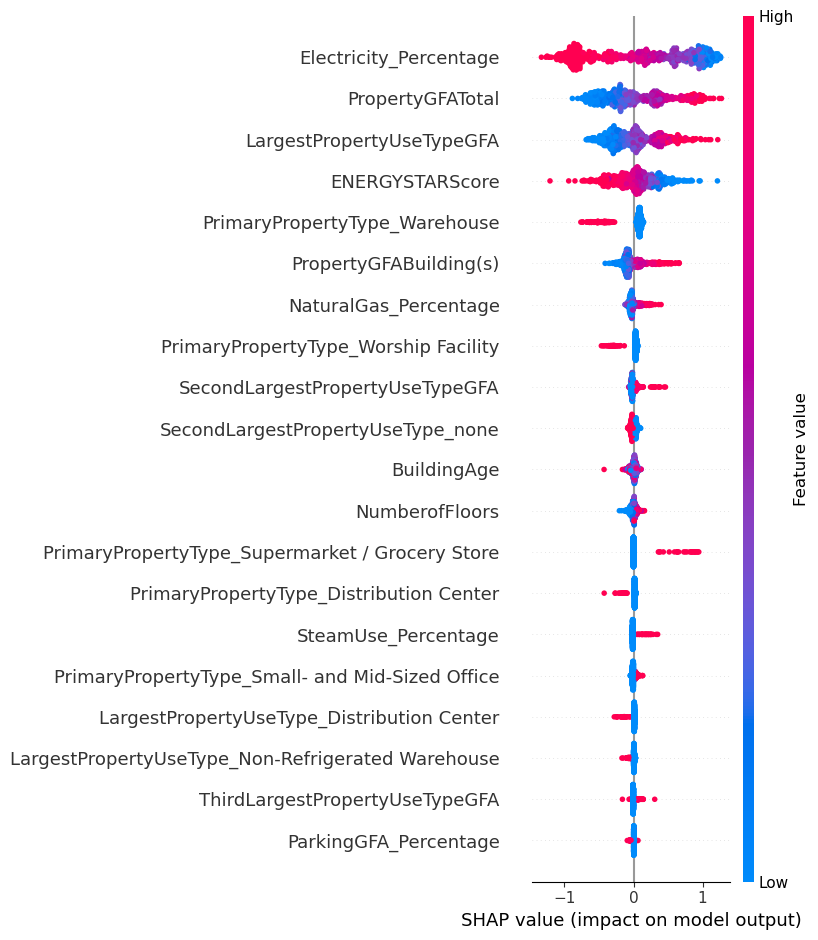

In [27]:
tryThisModel('XGBoost',energy_star_clean,Yghg_star,shap_explain=True)

In [26]:
results = pd.read_csv('U://DATA/OpenClassrooms/Data science/P4/result_df.csv')
print(results.sort_values(by=['best_score'], ascending=False).to_string())

                model                     X             y                                                                best_param  best_score   R2score      RMSE       MAE       time
20            XGBoost           energy_star     Yghg_star  {'m__learning_rate': 0.05, 'm__n_estimators': 500, 's__percentile': 100}    0.886426  0.858395  0.569509  0.426026  21.852997
17            XGBoost                     _     Yghg_star  {'m__learning_rate': 0.05, 'm__n_estimators': 500, 's__percentile': 100}    0.886426  0.858395  0.569509  0.426026  24.303876
18  Gradient Boosting                     _  Yenergy_star   {'m__learning_rate': 0.1, 'm__n_estimators': 500, 's__percentile': 100}    0.885157  0.886678  0.454274  0.345693  20.544304
19            XGBoost           energy_star  Yenergy_star   {'m__learning_rate': 0.05, 'm__n_estimators': 300, 's__percentile': 70}    0.878491  0.839930  0.539903  0.408379  18.486349
16            XGBoost                     _            __   {'m__learning_r